In [2]:
# Inspired by: https://github.com/pytorch/examples/blob/master/mnist/main.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [3]:
use_cuda   = False
batch_size = 15
learn_rate = 0.001
num_epochs = 20

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.0), (0.3081, 0.0))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=False, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convLayers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=3),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.fc = nn.Linear(500, 10)

    def forward(self, x):
        x = self.convLayers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.softmax(x, dim=0)

model = Net()
if use_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.0)
criterion = nn.CrossEntropyLoss()

In [9]:
from ipywidgets import FloatProgress
from IPython.display import display
import time

progress = FloatProgress(min=0, max=len(train_loader.dataset))
display(progress)

def train(num_epochs):
    model.train()
    
    stats = { phase: { key: [] for key in ["time", "loss"] } for phase in ["train", "val"] }
    
    for epoch in range(num_epochs):
        # For every training data
        running_loss = 0
        epoch_start_time = time.time()
        
        for batch_idx, (data, target) in enumerate(train_loader):
            progress.value = batch_idx * batch_size
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]
        
        time_elapsed = time.time() - epoch_start_time
        loss = running_loss / len(train_loader.dataset)
        
        stats["train"]["time"].append(time_elapsed)
        stats["train"]["loss"].append(loss)
        
        print("Epoch [{}/{}]\tTime: {:.0f}m {:.0f}s\tAverage loss = {:.6f}".format(
            epoch+1, num_epochs, time_elapsed // 60, time_elapsed % 60, loss)
        )
        
    return stats

stats = train(num_epochs)

A Jupyter Widget

Epoch [1/20]	Time: 0m 21s	Average loss = 0.151184
Epoch [2/20]	Time: 0m 22s	Average loss = 0.144256
Epoch [3/20]	Time: 0m 22s	Average loss = 0.137266
Epoch [4/20]	Time: 0m 22s	Average loss = 0.132485
Epoch [5/20]	Time: 0m 22s	Average loss = 0.129824
Epoch [6/20]	Time: 0m 22s	Average loss = 0.128507
Epoch [7/20]	Time: 0m 23s	Average loss = 0.127652
Epoch [8/20]	Time: 0m 21s	Average loss = 0.127188
Epoch [9/20]	Time: 0m 22s	Average loss = 0.126835
Epoch [10/20]	Time: 0m 22s	Average loss = 0.126459
Epoch [11/20]	Time: 0m 22s	Average loss = 0.126410
Epoch [12/20]	Time: 0m 21s	Average loss = 0.126193
Epoch [13/20]	Time: 0m 22s	Average loss = 0.126070
Epoch [14/20]	Time: 0m 21s	Average loss = 0.126061
Epoch [15/20]	Time: 0m 21s	Average loss = 0.125848
Epoch [16/20]	Time: 0m 21s	Average loss = 0.125789
Epoch [17/20]	Time: 0m 21s	Average loss = 0.125728
Epoch [18/20]	Time: 0m 21s	Average loss = 0.125662
Epoch [19/20]	Time: 0m 20s	Average loss = 0.125588
Epoch [20/20]	Time: 0m 21s	Average loss 

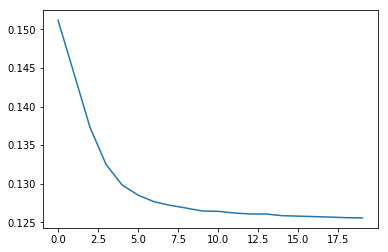

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(num_epochs), stats["train"]["loss"])

In [11]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]     # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print("Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)".format(
        test_loss, correct, len(test_loader.dataset),
        100.0 * correct / len(test_loader.dataset)))

test()

Test set: Average loss: 0.125668, Accuracy: 7718/10000 (77%)
